In [1]:
%matplotlib inline

import ROOT
tcanvas = ROOT.TCanvas("TCanvasName", "TCanvasTitle", 800, 600)

Welcome to JupyROOT 6.08/05


# Functional Playground

Let's back up and introduce the project properly.

No programming language is good at everything, and both C++ and Python are bad at parallel processing. Developing a good langauge for parallel processing is a frontier of computer science and has been for the past 20 years or so.

A few concepts are emerging as important for parallel processing:

   * **immutable, composable data**
   * **functionals instead of loops**
   * lazy evaluation
   * (actor-like isolation)
   * (asynchronous calls, callbacks, futures/promises)
   * (reactive APIs)

But only the first two or three are, in my opinion, relevant for _data analysis._

### Immutable, composable data

"Immutable" means that a quantity can't be changed after it has been created.

**Examples:**

   * In all programming languages, numbers are immutable. (Pascal let you change the definition of numbers like "4", but nothing about their internal structure. And even then, it was widely regarded as a terrible idea.)
   * In Python but not C++, strings are immutable. Operating on a string in Python always creates a new string; the old one is either kept or garbage collected. In C++, you can change individual characters of a string, which makes string processing much more complicated.
   * In "purely functional" languages like Haskell, _all_ data are immutable. Every little change requires a new data structure.

"Composable" means that you can use existing data to make new data. When you can't change data in-place, composing becomes the primary way of operating on data.

**Why is this important?**

Because if you have multiple computers looking at the same data, they are necessarily looking at different _copies_ of the data. Any transfer of data through space is, strictly speaking, a copy. The original may or may not be deleted after or during the copy.

If a processor is allowed to change its copy of the data in-place, then the others either become out of date or have to be updated. Pausing processing to update a variable's state slows down processing, defeating the purpose of parallel processing. Thus, it's good to avoid it.

### Functionals instead of loops

A "functional" is a function that takes functions as arguments. (Other words for this are "functors" and "higher-order functions," but "functional" is used more in a physics context.)

You may remember functionals from classical or quantum mechanics: a Lagrangian is a functional that takes a field and its derivative as arguments, both of which are functions defined on all space-time, and returns a real number.

Two functionals have become very popular recently: `map` and `reduce`. The Hadoop framework, also known as "map-reduce," implements the `map` and `reduce` functionals over a cluster of networked computers, so that a data analyst only has to write their problem as functions to pass into `map` and `reduce` to submit their job.

Below, we'll play with `map`, `reduce`, and several other useful functionals.

### Lazy evaluation

Sometimes relevant for data analysis. A programming task can either be executed exactly where it is written or it may be delayed for later execution. "Lazy evaluation" is when the programming environment executes an expression at the latest possible time.

This concept was integrated into CMSSW's pipelines, so that producers are only invoked when and if their data are needed.

In Python, we see this distinction between lists, which are fully evaluated data in memory, and generators, which produce data on demand (lazily).

When data are evaluated lazily, they don't need to be finite. We'll be working with an infinite stream of CMS events.

# Functional programming in Python

The next three cells augment Python to make it more functional. We'll use it to tinker with data analysis in a functional setting as 



In [2]:
#### Please ignore the man behind the curtain...
#### This is just a hack to add new methods to Python's built-in types.

import ctypes

if hasattr(ctypes.pythonapi, "Py_InitModule4_64"):
    Py_ssize_t = ctypes.c_int64
else:
    ctypes.c_int

class PyObject(ctypes.Structure): pass
PyObject._fields_ = [("ob_refcnt", Py_ssize_t), ("ob_type", ctypes.POINTER(PyObject))]

class SlotsPointer(PyObject):
    _fields_ = [("dict", ctypes.POINTER(PyObject))]

def proxy_builtin(cls):
    name = cls.__name__
    slots = getattr(cls, "__dict__", name)

    pointer = SlotsPointer.from_address(id(slots))
    namespace = {}

    ctypes.pythonapi.PyDict_SetItem(
        ctypes.py_object(namespace),
        ctypes.py_object(name),
        pointer.dict
    )

    return namespace[name]

In [3]:
#### Attach functional methods to the Python "list" type.

def sizer(lst):
    """
    Return the length of the list.
    
    Example: [1, 2, 3, 4, 5].size == 5
    
    (For convenience, since everything else is attached at the end of a chain of methods.)
    """
    return len(lst)

def taker(lst):
    """
    Return the first n elements of the list.
    
    Example: [1, 2, 3, 4, 5].take(3) == [1, 2, 3]
    """
    if isinstance(lst, list):
        return lambda n: lst[:n]
    else:
        def gen(n):
            for i, x in enumerate(lst):
                yield x
                if i + 1 >= n: break
        return gen

def mapper(lst):
    """
    Apply a given function to each element of this list.
    
    The function must take one argument.
    
    Examples: [1, 2, 3, 4, 5].map(f) == [f(1), f(2), f(3), f(4), f(5)]
              [1, 2, 3, 4, 5].map(lambda x: x + 100) == [101, 102, 103, 104, 105]
    """
    if isinstance(lst, list):
        return lambda f: [f(x) for x in lst]
    else:
        return lambda f: (f(x) for x in lst)

def flattener(lst):
    """
    Turn a list-of-lists into a list of all elements. Only reduces one level of structure.
        
    Examples: [[1, 2], [3, 4, 5]].flatten == [1, 2, 3, 4, 5]
              [[1, 2], [3, [4, 5]]].flatten == [1, 2, 3, [4, 5]
    """
    if isinstance(lst, list):
        return sum(lst, [])
    else:
        def gen():
            for x in lst:
                for y in x:
                    yield y
        return gen()

def flatmapper(lst):
    """
    Same as [...].map(f).flatten, but these two operations are frequently done together.
    
    The function must take one argument.
    
    In general: [...].flatmap(f) == [...].map(f).flatten
    
    Example: [1, 2, 3, 4, 5].flatmap(lambda x: [x, x + 100]) == [1, 101, 2, 102, 3, 103, 4, 104, 5, 105]
    
    Flatmap is a very general operation. You can use it to expand a table, as above, or to map and filter
    at the same time. (In the theory of monads, "flatmap" is the fundamental "bind" operation.)
    
    Example: [1, 2, 3, 4, 5].flatmap(lambda x: [100 + x] if x > 2 else []) == [103, 104, 105]
    
    You might encounter this when you want to compute something for all particles in each event, but also
    handle the case when there are no particles after cuts. In that case, "flatmap" instead of "map" and
    return a singleton list [result] when you have a result and an empty list [] when you don't.
    """
    if isinstance(lst, list):
        return lambda f: sum((f(x) for x in lst), [])
    else:
        def gen(f):
            for x in lst:
                for y in f(x):
                    yield y
        return gen

def filterer(lst):
    """
    Apply a given function to each element of the list and return only those that return True.
    
    The function must take one argument and return True or False.
    
    Example: [1, 2, 3, 4, 5].filter(lambda x: x > 2) == [3, 4, 5]
    """
    if isinstance(lst, list):
        return lambda f: [x for x in lst if f(x)]
    else:
        def gen(f):
            for x in lst:
                if f(x):
                    yield x
        return gen
    
def reducer(lst):
    """
    Apply a given function to each element and a running tally to produce a single result.
    
    The function must take two arguments. The first may be an element from the list or a tally.
    The second will always be from the list.
    
    Examples: [1, 2, 3, 4, 5].reduce(f) == f(f(f(f(1, 2), 3), 4), 5)
              [1, 2, 3, 4, 5].reduce(lambda x, y: x + y) == 15
    """
    return lambda f: reduce(f, lst)

def aggregator(lst):
    """
    Same as reduce, except start the aggregation on a given zero element.
    
    The function must take two arguments. The first will always be a tally and the second from the list.
    
    Examples: [1, 2, 3, 4, 5].aggregate(f, 0) == f(f(f(f(f(0, 1), 2), 3), 4), 5)
              [1, 2, 3, 4, 5].aggregate(lambda x, y: x + y, 0) == 15
              ("a", "b", "c").aggregate(lambda x, y: x + y, "") == "abc"
    """
    return lambda f, zero: reduce(f, lst, zero)

def reducerright(lst):
    """
    Same as reduce, except start the nesting on the right and work left.
    
    The function must take two arguments. The second may be an element from the list or a tally.
    The first will always be from the list.
    
    Example: [1, 2, 3, 4, 5].reduceright(f) == f(1, f(2, f(3, f(4, 5))))
    """
    return lambda f: reduce(lambda a, b: f(b, a), reversed(lst))

def aggregatorright(lst):
    """
    Same as aggregate, except start the nesting on the right and work left.
    
    The function must take two arguments. The second will always be a tally and the first from the list.
    
    Example: [1, 2, 3, 4, 5].aggregateright(f, 0) == f(1, f(2, f(3, f(4, f(5, 0)))))
    """
    return lambda f, zero: reduce(lambda a, b: f(b, a), reversed(lst), zero)

def pairser(lst):
    """
    Apply a given function to pairs of elements without repetition (in either order) or duplicates.
    
    The function must take two arguments. Both will always be elements from the list.
    
    If you think of the input list as a vector X, this acts on the upper trianglular part of the
    outer product of X with X (not including diagonal).
    
    Alternatively, it's what you would get from these nested loops:
    
        for i in range(len(lst)):
            for j in range(i + 1, len(lst)):   # j starts at i + 1
                f(lst[i], lst[j])
    
    Example: [1, 2, 3, 4, 5].pairs(lambda x, y: [x, y]) == [[1, 2], [1, 3], [1, 4], [1, 5],
                                                                    [2, 3], [2, 4], [2, 5],
                                                                            [3, 4], [3, 5],
                                                                                    [4, 5]]
    
    Use this when you want to loop over pairs of distinct pairs of elements from a single list.
    
    Contrast with "table", which is like a nested loop over several lists, for all elements.
    """
    return lambda f: [f(x, y) for i, x in enumerate(lst) for y in lst[i + 1:]]

def tabler(lsts):
    """
    Apply a given function to all combinations of elements from all input lists.
    
    The function must take as many arguments as you have lists, and each will be an element from
    each list.
    
    If you think of the input lists as vectors X, Y, Z, etc., this acts on each element of the
    outer product of X with Y with Z, etc.
    
    Alternatively, it's what you would get from these nested loops:
    
        for x in lst_x:
            for y in lst_y:
                for z in lst_z:
                    f(x, y, z)
    
    Examples: [[100, 200], [1, 2, 3]].table(lambda x, y: x + y) == [101, 102, 103, 201, 202, 203]
    
              [[100, 200], [10, 20], [1, 2]].table(lambda x, y, z: x + y + z) == [
                  111, 112, 121, 122, 211, 212, 221, 222]

    To illustrate the difference between table and pairs, consider the following:

        [1, 2, 3].pairs(lambda x, y: [x, y]) == [[1, 2], [1, 3],
                                                         [2, 3]]
        
        [[1, 2, 3], [1, 2, 3]].table(lambda x, y: [x, y]) == [[1, 1], [1, 2], [1, 3],
                                                              [2, 1], [2, 2], [2, 3],
                                                              [3, 1], [3, 2], [3, 3]]
    """
    def buildargs(first, *rest):
        if len(rest) == 0:
            return [[x] for x in first]
        else:
            return [[x] + y for x in first for y in buildargs(*rest)]

    if len(lsts) < 2:
        raise TypeError("table requires at least two arguments")
    else:
        first = lsts[0]
        rest = lsts[1:]
        return lambda f: [f(*args) for args in buildargs(first, *rest)]

def zipper(lsts):
    """
    Apply a function to the ith element of each list, for all i.
    
    The function must take as many arguments as there are lists, and each will be an element from
    each list.
    
    This works just like the built-in Python zip, but applies the function to its results:
    
        for x, y, z in zip(lst_x, lst_y, lst_z):
            f(x, y, z)
    
    Example: [[1, 2, 3], ["a", "b", "c"], [101, 102, 103]].zip(lambda x, y, z: (x, y, z)) == [
                 (1, "a", 101), (2, "b", 102), (3, "c", 103)]
    """
    if len(lsts) < 2:
        raise TypeError("zip requires at least two arguments")
    else:
        return lambda f: [f(*args) for args in zip(*lsts)]

# attach the methods                                               force Python to notice
proxy_builtin(list)["size"] = property(sizer);                     hasattr((), "size")
proxy_builtin(list)["take"] = property(taker);                     hasattr((), "take")
proxy_builtin(list)["map"] = property(mapper);                     hasattr((), "map")
proxy_builtin(list)["flatten"] = property(flattener);              hasattr((), "flatten")
proxy_builtin(list)["flatmap"] = property(flatmapper);             hasattr((), "flatmap")
proxy_builtin(list)["filter"] = property(filterer);                hasattr((), "filter")
proxy_builtin(list)["reduce"] = property(reducer);                 hasattr((), "reduce")
proxy_builtin(list)["aggregate"] = property(aggregator);           hasattr((), "aggregate")
proxy_builtin(list)["reduceright"] = property(reducerright);       hasattr((), "reduceright")
proxy_builtin(list)["aggregateright"] = property(aggregatorright); hasattr((), "aggregateright")
proxy_builtin(list)["pairs"] = property(pairser);                  hasattr((), "pairs")
proxy_builtin(list)["table"] = property(tabler);                   hasattr((), "table")
proxy_builtin(list)["zip"] = property(zipper);                     hasattr((), "zip")

([].take, [].map, [].flatten, [].flatmap, [].filter, [].reduce, [].aggregate,
 [].reduceright, [].aggregateright, [].pairs, [[], []].table, [[], []].zip)

(<function __main__.<lambda>>,
 <function __main__.<lambda>>,
 [],
 <function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>)

In [4]:
# Verify that they all work (and provide examples of their use).

assert [1, 2, 3, 4, 5].take(3) == [1, 2, 3]

assert [1, 2, 3, 4, 5].map(lambda x: 100 + x) == [101, 102, 103, 104, 105]

assert [[1, 2], [3, 4, 5]].flatten == [1, 2, 3, 4, 5]
assert [[1, 2], [3, [4, 5]]].flatten == [1, 2, 3, [4, 5]]

assert [1, 2, 3, 4, 5].map(lambda x: [x, x + 100]) == [[1, 101], [2, 102], [3, 103], [4, 104], [5, 105]]
assert [1, 2, 3, 4, 5].map(lambda x: [x, x + 100]).flatten == [1, 101, 2, 102, 3, 103, 4, 104, 5, 105]
assert [1, 2, 3, 4, 5].flatmap(lambda x: [x, x + 100]) == [1, 101, 2, 102, 3, 103, 4, 104, 5, 105]
assert [1, 2, 3, 4, 5].flatmap(lambda x: [100 + x] if x > 2 else []) == [103, 104, 105]

assert [1, 2, 3, 4, 5].filter(lambda x: x > 2) == [3, 4, 5]

assert [1, 2, 3, 4, 5].reduce(lambda x, y: x + y) == 15
assert [1, 2, 3, 4, 5].reduce(lambda x, y: [x, y]) == [[[[1, 2], 3], 4], 5]

assert ["a", "b", "c"].aggregate(lambda x, y: x + y, "") == "abc"
assert [1, 2, 3, 4, 5].aggregate(lambda x, y: [x, y], []) == [[[[[[], 1], 2], 3], 4], 5]

assert [1, 2, 3, 4, 5].reduceright(lambda x, y: [x, y]) == [1, [2, [3, [4, 5]]]]

assert [1, 2, 3, 4, 5].aggregateright(lambda x, y: [x, y], []) == [1, [2, [3, [4, [5, []]]]]]

assert [1, 2, 3, 4, 5].pairs(lambda x, y: [x, y]) == [[1, 2], [1, 3], [1, 4], [1, 5], [2, 3],
                                                      [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]

assert [[100, 200], [1, 2, 3]].table(lambda x, y: x + y) == [101, 102, 103, 201, 202, 203]
assert [[100, 200], [10, 20], [1, 2]].table(lambda x, y, z: x + y + z) == [111, 112, 121, 122, 211, 212, 221, 222]
assert [[1, 2, 3, 4, 5], ["a", "b"]].table(lambda x, y: [x, y]) == [
    [1, "a"], [1, "b"], [2, "a"], [2, "b"], [3, "a"], [3, "b"], [4, "a"], [4, "b"], [5, "a"], [5, "b"]]
assert [1, 2, 3].pairs(lambda x, y: [x, y]) == [[1, 2], [1, 3], [2, 3]]
assert [[1, 2, 3], [1, 2, 3]].table(lambda x, y: [x, y]) == [[1, 1], [1, 2], [1, 3],
                                                             [2, 1], [2, 2], [2, 3],
                                                             [3, 1], [3, 2], [3, 3]]

assert [[1, 2, 3], ["a", "b", "c"], [101, 102, 103]].zip(lambda x, y, z: [x, y, z]) == [
    [1, "a", 101], [2, "b", 102], [3, "c", 103]]

In [5]:
from histogrammar import *
from histogrammar.tutorial import cmsdata

def InfiniteEvents():
    while True:
        for event in cmsdata.EventIterator():
            yield event

events = InfiniteEvents()

In [6]:
proxy_builtin(type(events))["take"] = property(taker);                     hasattr(events, "take")
proxy_builtin(type(events))["map"] = property(mapper);                     hasattr(events, "map")
proxy_builtin(type(events))["flatten"] = property(flattener);              hasattr(events, "flatten")
proxy_builtin(type(events))["flatmap"] = property(flatmapper);             hasattr(events, "flatmap")
proxy_builtin(type(events))["filter"] = property(filterer);                hasattr(events, "filter")
proxy_builtin(type(events))["reduce"] = property(reducer);                 hasattr(events, "reduce")
proxy_builtin(type(events))["aggregate"] = property(aggregator);           hasattr(events, "aggregate")
proxy_builtin(type(events))["reduceright"] = property(reducerright);       hasattr(events, "reduceright")
proxy_builtin(type(events))["aggregateright"] = property(aggregatorright); hasattr(events, "aggregateright")

True

In [7]:
def dimuon(event):
    mu1, mu2 = event.muons[:2]
    return (mu1 + mu2).mass

list(events.filter(lambda ev: ev.muons.size >= 2).map(dimuon).take(20))

[88.9468251097268,
 40.915272726635216,
 89.88667775372531,
 92.50889570173612,
 87.33151684752877,
 86.73589857883964,
 17.215447985795976,
 90.59405647767977,
 99.54980031423942,
 90.16057143550684,
 93.47173495498177,
 3.953625857643265,
 3.934012322364818,
 45.08225898569615,
 79.15001349842068,
 84.05077693770595,
 93.45965877179938,
 91.31698863152324,
 91.19897690101983,
 93.86448335113091]

In [8]:
def histogrammarMethod(cls):
    def generatorProperty(lst):
        def hargs(*args, **kwds):
            h = cls(*args, **kwds)
            for x in lst:
                h.fill(x)
            return h
        return hargs
    return generatorProperty

proxy_builtin(type(events))["Average"] = property(histogrammarMethod(Average))
proxy_builtin(type(events))["Bin"] = property(histogrammarMethod(Bin))
proxy_builtin(type(events))["Categorize"] = property(histogrammarMethod(Categorize))
proxy_builtin(type(events))["CentrallyBin"] = property(histogrammarMethod(CentrallyBin))
proxy_builtin(type(events))["Label"] = property(histogrammarMethod(Label))
proxy_builtin(type(events))["Bundle"] = property(histogrammarMethod(UntypedLabel))  # rename like HG 2.0
proxy_builtin(type(events))["Index"] = property(histogrammarMethod(Index))
proxy_builtin(type(events))["Branch"] = property(histogrammarMethod(Branch))
proxy_builtin(type(events))["Count"] = property(histogrammarMethod(Count))
proxy_builtin(type(events))["Deviate"] = property(histogrammarMethod(Deviate))
proxy_builtin(type(events))["Fraction"] = property(histogrammarMethod(Fraction))
proxy_builtin(type(events))["IrregularlyBin"] = property(histogrammarMethod(IrregularlyBin))
proxy_builtin(type(events))["Minimize"] = property(histogrammarMethod(Minimize))
proxy_builtin(type(events))["Maximize"] = property(histogrammarMethod(Maximize))
proxy_builtin(type(events))["Select"] = property(histogrammarMethod(Select))
proxy_builtin(type(events))["SparselyBin"] = property(histogrammarMethod(SparselyBin))
proxy_builtin(type(events))["Stack"] = property(histogrammarMethod(Stack))
proxy_builtin(type(events))["Sum"] = property(histogrammarMethod(Sum))

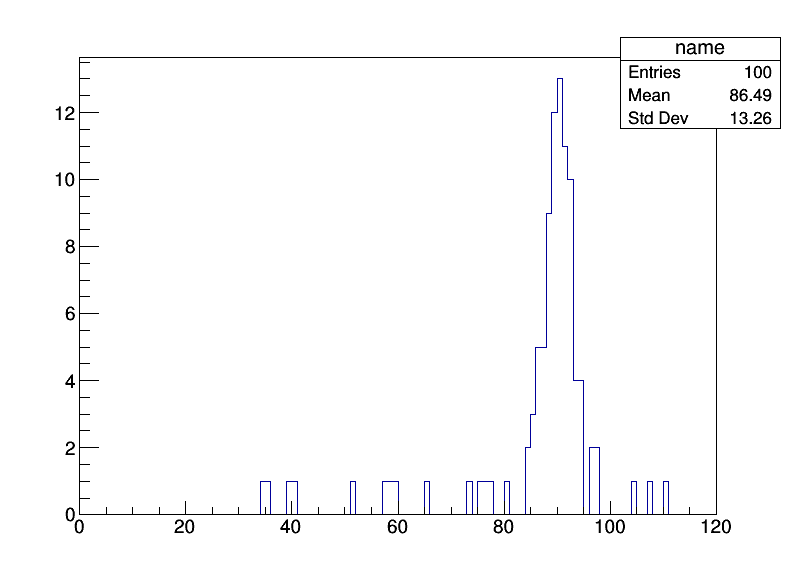

In [9]:
th1 = events.filter(lambda ev: ev.muons.size >= 2).take(100).Bin(120, 0, 120, dimuon).plot.root("name")
th1.Draw()
tcanvas.Draw()